# Variational AutoEncoders

Full Name: Mahdi Tabatabaei	

Student ID: 400101515


# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and a conditional variational autoencoder with slightly different architectures and apply them to the popular MNIST handwritten dataset.

Load several useful packages that are used in this notebook:

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import random
import cv2
import matplotlib as mpl
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [3]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load MNIST Dataset


VAEs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset.

In [4]:
batch_size = 128

mnist_train = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.3MB/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.67MB/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



## Visualize dataset

It is always a good idea to look at examples from the dataset before working with it. Let's visualize the digits in the MNIST dataset. We have defined the function `show_images` to visualize the images.


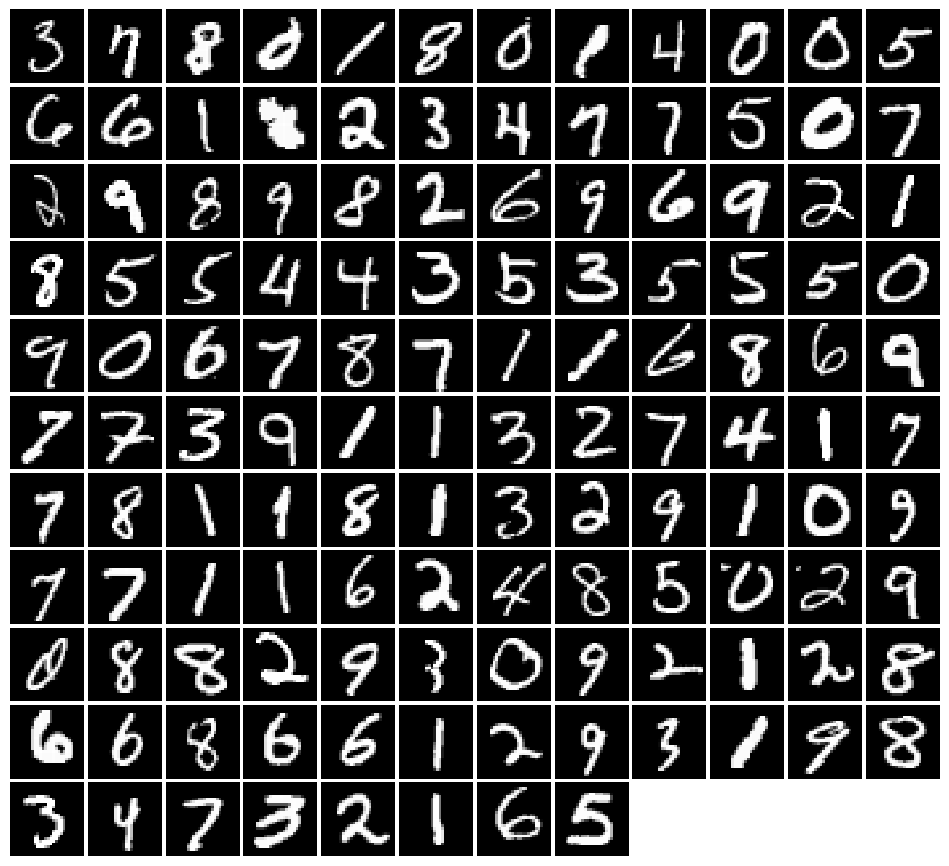

In [5]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

data_iter = iter(loader_train)
imgs, _ = next(data_iter)
imgs = imgs.view(batch_size, 784)
show_images(imgs)

# Fully Connected VAE

Your first VAE implementation will consist solely of fully connected layers. You'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. In this section you'll define the Encoder and Decoder models in the VAE class and implement the reparametrization trick, forward pass, and loss function to train your first VAE.

## FC-VAE Forward

Complete the VAE class by writing the initialization and the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.



In [6]:
class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device):
        super(VAE_MLP, self).__init__()
        self.device = device

        # Encoder: From input (784) to latent (mean and log-variance)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Latent space parameters: mean and log-variance
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: From latent (latent_dim) to reconstructed input (784)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Sigmoid for output between [0, 1] (as MNIST images)
        )

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)  # Standard deviation from log-variance
        eps = torch.randn_like(std)  # Sample epsilon from standard normal
        z = mu + eps * std  # Latent variable z
        return z

    def forward(self, x):
        # Flatten input image
        x = x.view(-1, 784)
        
        # Pass through encoder
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        # Reparameterize to sample from latent space
        z = self.reparameterize(mu, logvar)
        
        # Pass through decoder to reconstruct the image
        recon_x = self.decoder(z)
        
        return recon_x, mu, logvar



## Loss Function

Complete the vae_loss function below

In [13]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
        
    BCE = F.binary_cross_entropy(recon, data.view(-1, 784), reduction='sum')

    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss is the sum of reconstruction loss and KL divergence
    return BCE + KL_div


## Train a model

Now that we have our VAE defined and loss function ready, lets train our model!

Complete the train_vae_mlp function to train the network.

In [30]:
def train_vae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    model.train()  # Set model to training mode
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check for GPU

    # Move the model to the correct device (CPU or CUDA)
    model.to(device)

    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []  # To accumulate the loss for the epoch

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)  # Move data to the same device as the model
            data = data.view(-1, 784)  # Flatten the input data (batch_size, 784)
            
            # Zero gradients before the backward pass
            optimizer.zero_grad()

            # Forward pass through the VAE model
            recon_batch, mu, logvar = model(data)

            # Compute the VAE loss
            loss = vae_loss(recon_batch, data, mu, logvar)

            # Backpropagation
            loss.backward()

            # Update the model parameters
            optimizer.step()

            # Store the loss for later averaging
            total_loss.append(loss.item())

        # Calculate the average loss for the epoch
        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f'VAE - Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')


In [32]:
latent_size = 20  
input_dim = 784  
hidden_dim = 400  

# Initialize the model
VAE = VAE_MLP(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_size, device=device)

# Train the model
train_vae_mlp(VAE, loader_train, num_epochs=num_epochs, learning_rate=learning_rate)



VAE - Epoch [1/20], Loss: 22770.8850

VAE - Epoch [2/20], Loss: 16427.8435

VAE - Epoch [3/20], Loss: 15071.5253

VAE - Epoch [4/20], Loss: 14446.4288

VAE - Epoch [5/20], Loss: 14054.1201

VAE - Epoch [6/20], Loss: 13813.6599

VAE - Epoch [7/20], Loss: 13639.5592

VAE - Epoch [8/20], Loss: 13503.7463

VAE - Epoch [9/20], Loss: 13395.0440

VAE - Epoch [10/20], Loss: 13298.8931

VAE - Epoch [11/20], Loss: 13224.1993

VAE - Epoch [12/20], Loss: 13163.9472

VAE - Epoch [13/20], Loss: 13099.1963

VAE - Epoch [14/20], Loss: 13053.4103

VAE - Epoch [15/20], Loss: 13011.3852

VAE - Epoch [16/20], Loss: 12969.9542

VAE - Epoch [17/20], Loss: 12938.4424

VAE - Epoch [18/20], Loss: 12904.7672

VAE - Epoch [19/20], Loss: 12868.3964

VAE - Epoch [20/20], Loss: 12845.1460


## Visualize results

After training our VAE network, we're able to take advantage of its power to generate new training examples. This process simply involves the decoder: we intialize some random distribution for our latent spaces z, and generate new examples by passing these latent space into the decoder.

Run the cell below to generate new images! You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed. Our next model will see improvement in these results.

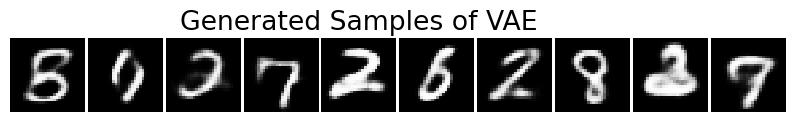

In [33]:
num_samples = 10
z = torch.randn(num_samples, latent_size).to(device=device)

VAE.eval()
samples = VAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    if i == 4:
      plt.title('Generated Samples of VAE')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='Greys_r')

# Conditional FC-VAE

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new digits randomly.

## Define Network with class input

Your CVAE architecture should be the same as your FC-VAE architecture, except you'll now concatenate a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space.

If the one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE_MLP` class use the same FC-VAE architecture implemented in the last network.


In [17]:
class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, device):
        super(CVAE_MLP, self).__init__()
        self.device = device

        # Encoder: Takes in x (flattened image) and y (one-hot label)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Latent space parameters: mean and log-variance
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: Takes in z (latent variable) and y (one-hot label)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output values between [0, 1] for MNIST
        )

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample z ~ q(z|x, y)
        """
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)   # Sample epsilon from N(0, 1)
        z = mu + eps * std  # Reparameterized latent variable
        return z

    def forward(self, x, y):
        """
        Forward pass for the CVAE.
        x: Input image (batch_size x input_dim)
        y: One-hot encoded label (batch_size x num_classes)
        """
        # Flatten x and ensure y is properly shaped
        x = x.view(x.size(0), -1)  # Flatten input
        y = y.view(y.size(0), -1)  # Ensure y is (batch_size x num_classes)

        # Concatenate x and y for the encoder
        encoder_input = torch.cat([x, y], dim=1)
        h = self.encoder(encoder_input)

        # Get latent space parameters
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Reparameterize to sample z
        z = self.reparameterize(mu, logvar)

        # Concatenate z and y for the decoder
        decoder_input = torch.cat([z, y], dim=1)
        recon_x = self.decoder(decoder_input)

        return recon_x, mu, logvar


If you want to build helper functions, you can write the code in the below cell.

# Loss Function

Complete the cvae_loss function below

In [16]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data and reconstruction tensors to match shapes
    data = data.view(data.size(0), -1)
    recon = recon.view(recon.size(0), -1)

    # Reconstruction loss (Binary Cross-Entropy between recon and data)
    recon_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    # KL = 0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction (optional)
    if class_logits is not None and labels is not None:
        # Apply cross-entropy loss for class prediction
        class_loss = F.cross_entropy(class_logits, labels, reduction='sum')
    else:
        class_loss = 0.0

    # Total loss
    total_loss = recon_loss + kl_loss + class_loss
    return total_loss


## Train model

Using the same training script, let's now train our CVAE!



In [19]:
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()  # Set the model to training mode
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose device (GPU or CPU)
    model.to(device)  # Move the model to the device (GPU/CPU)

    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []  # To store the loss values for each batch

        for batch_idx, (data, labels) in enumerate(train_loader):
            # Move the data and labels to the appropriate device (GPU or CPU)
            data, labels = data.to(device), labels.to(device)

            # One-hot encode the labels
            y = F.one_hot(labels, num_classes=10).float()  # Convert labels to one-hot encoding (10 classes)

            # Flatten the input images
            data = data.view(data.size(0), -1)  # Flatten the images (batch_size, 784)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass through the model
            recon_batch, mu, logvar = model(data, y)

            # Compute the loss
            loss = cvae_loss(recon_batch, data, mu, logvar, class_logits=None, labels=None)

            # Backpropagation
            loss.backward()

            # Update the model parameters
            optimizer.step()

            # Append the loss to the total loss list
            total_loss.append(loss.item())

        # Calculate the average loss for this epoch
        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f'CVAE-MLP Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')


In [20]:
# Hyperparameters
latent_size = 20  # Latent space size
input_dim = 784  # Flattened MNIST image size (28x28)
hidden_dim = 400  # Hidden layer size
num_classes = 10  # Number of classes for MNIST (digits 0-9)
num_epochs = 10  # Number of epochs for training
learning_rate = 1e-3  # Learning rate for optimizer

# Device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the CVAE model
CVAE = CVAE_MLP(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_size, num_classes=num_classes, device=device)

# Train the CVAE model
train_cvae_mlp(CVAE, loader_train, num_epochs=num_epochs, learning_rate=learning_rate)



CVAE-MLP Epoch [1/10], Loss: 21529.7171

CVAE-MLP Epoch [2/10], Loss: 15662.8635

CVAE-MLP Epoch [3/10], Loss: 14558.9956

CVAE-MLP Epoch [4/10], Loss: 13966.0461

CVAE-MLP Epoch [5/10], Loss: 13586.4978

CVAE-MLP Epoch [6/10], Loss: 13341.1680

CVAE-MLP Epoch [7/10], Loss: 13142.2242

CVAE-MLP Epoch [8/10], Loss: 12994.1474

CVAE-MLP Epoch [9/10], Loss: 12870.0098

CVAE-MLP Epoch [10/10], Loss: 12763.1355


## Visualize Results

You've trained your CVAE, now let's conditionally generate some new data! This time, we can specify the class we want to generate by adding our one hot matrix of class labels. We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit. When you run the cell below, you should get one example per digit. Each digit should be reasonably distinguishable (it is ok to run this cell a few times to save your best results).



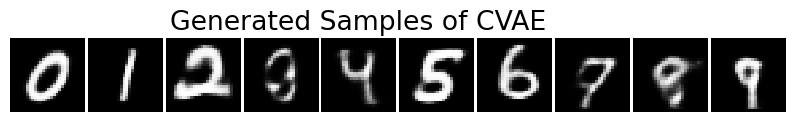

In [21]:
num_samples = 10
z = torch.randn(num_samples, latent_size)

c = torch.eye(num_samples, 10)

z = torch.cat((z,c), dim=-1).to(device='cuda')
CVAE.eval()
samples = CVAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    if i == 4:
      plt.title('Generated Samples of CVAE')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')